### **TABL**

In [ ]:
# load packages

import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm import tqdm 
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import torch
from torch.utils import data
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


### **Data**
The dataset in the folder Dataset is the FI-2010 dataset zipped and normalized. 

As in the original paper I used the firs 7 days to train and to validate, and the rest 3 days to do the the testing. 

In [ ]:
# please change the data_path to your local path and download the files you need from the web site of the dataset

dec_data = np.loadtxt('/content/drive/MyDrive/Data/Train_Dst_NoAuction_ZScore_CF_7.txt')
dec_train = dec_data[:, :int(dec_data.shape[1] * 0.8)]
dec_val = dec_data[:, int(dec_data.shape[1] * 0.8):]

dec_test1 = np.loadtxt('/content/drive/MyDrive/Data/Test_Dst_NoAuction_ZScore_CF_7.txt')
dec_test2 = np.loadtxt('/content/drive/MyDrive/Data/Test_Dst_NoAuction_ZScore_CF_8.txt')
dec_test3 = np.loadtxt('/content/drive/MyDrive/Data/Test_Dst_NoAuction_ZScore_CF_9.txt')
dec_test = np.hstack((dec_test1, dec_test2, dec_test3))

h = 2        #if h = 2, than horizon = 50

y_train = dec_train[-h, :].flatten()
y_val = dec_val[-h, :].flatten()
y_test = dec_test[-h, :].flatten()

y_train = y_train[9:] - 1
y_val = y_val[9:] - 1
y_test = y_test[9:] - 1 

dec_train = dec_train[:40, :].T
dec_val = dec_val[:40, :].T
dec_test = dec_test[:40, :].T

print(dec_train.shape)


In [ ]:
#computing the weights for a weighted cross entropy loss

y = np.concatenate((y_train, y_val, y_test))
weights = torch.zeros(3, device=device)
for i in range(y.shape[0]):
  if (y[i] == 0):
    weights[0] += 1
  elif (y[i] == 1):
    weights[1] += 1
  else:
    weights[2] += 1
weights = weights / y.shape[0]
print(weights)

In [ ]:
class Dataset(data.Dataset):
    """Characterizes a dataset for PyTorch"""
    def __init__(self, x, y, num_classes, n, dim):
        """Initialization""" 
        self.num_classes = num_classes
        self.dim = dim
        self.x = x   
        self.y = y
        self.n = n

        self.length = x.shape[0] - (T/10) -self.dim + 1
        print(self.length)

        x = torch.from_numpy(x)
        self.x = torch.unsqueeze(x, 1)
        self.y = torch.from_numpy(y)

    def __len__(self):
        """Denotes the total number of samples"""
        return int(self.length)

    def __getitem__(self, i):
        input = self.x[i:i+self.dim, :]
        input = input.permute(1, 2, 0)
        input = torch.squeeze(input)

        return input, self.y[i]

In [ ]:
#Hyperparameters

batch_size = 256
epochs = 200
T = 50   #horizon    
lr = 0.01
num_classes = 3
dim = 10
n = 3 


dataset_val = Dataset(dec_val, y_val, num_classes, n, dim)
dataset_test = Dataset(dec_test, y_test, num_classes, n, dim)
dataset_train = Dataset(dec_train, y_train, num_classes, n, dim)

train_loader = torch.utils.data.DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=dataset_val, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=dataset_test, batch_size=batch_size, shuffle=False)

50936.0
139573.0
203786.0


### **Model Architecture**


In [ ]:


class TABL_layer(nn.Module):
    def __init__(self, d2, d1, t1, t2):
        super().__init__()
        self.t1 = t1

        weight = torch.Tensor(d2, d1)
        self.W1 = nn.Parameter(weight)
        nn.init.kaiming_uniform_(self.W1, nonlinearity='relu')
        
        weight2 = torch.Tensor(t1, t1)
        self.W = nn.Parameter(weight2)
        nn.init.constant_(self.W, 1/t1)
 
        weight3 = torch.Tensor(t1, t2)
        self.W2 = nn.Parameter(weight3)
        nn.init.kaiming_uniform_(self.W2, nonlinearity='relu')

        bias1 = torch.Tensor(d2, t2)
        self.B = nn.Parameter(bias1)
        nn.init.constant_(self.B, 0)

        l = torch.Tensor(1,)
        self.l = nn.Parameter(l)
        nn.init.constant_(self.l, 0.5)

        self.activation = nn.ReLU()

    def forward(self, X):
        
        #maintaining the weight parameter between 0 and 1.
        if (self.l[0] < 0): 
          l = torch.Tensor(1,)
          self.l = nn.Parameter(l)
          nn.init.constant_(self.l, 0.0)

        if (self.l[0] > 1): 
          l = torch.Tensor(1,)
          self.l = nn.Parameter(l)
          nn.init.constant_(self.l, 1.0)
     
        #modelling the dependence along the first mode of X while keeping the temporal order intact (7)
        X = self.W1 @ X

        #enforcing constant (1) on the diagonal
        W = self.W -self.W *torch.eye(self.t1,dtype=torch.float32).to(device)+torch.eye(self.t1,dtype=torch.float32).to(device)/self.t1

        #attention, the aim of the second step is to learn how important the temporal instances are to each other (8)
        E = X @ W

        #computing the attention mask  (9)
        A = torch.softmax(E, dim=-1)

        #applying a soft attention mechanism  (10)
        #he attention mask A obtained from the third step is used to zero out the effect of unimportant elements
        X = self.l[0] * (X) + (1.0 - self.l[0])*X*A

        #the final step of the proposed layer estimates the temporal mapping W2, after the bias shift (11)
        y = X @ self.W2 + self.B
        return y

class BL_layer(nn.Module):
  def __init__(self, d2, d1, t1, t2):
        super().__init__()
        weight1 = torch.Tensor(d2, d1)
        self.W1 = nn.Parameter(weight1)
        nn.init.kaiming_uniform_(self.W1, nonlinearity='relu')

        weight2 = torch.Tensor(t1, t2)
        self.W2 = nn.Parameter(weight2)
        nn.init.kaiming_uniform_(self.W2, nonlinearity='relu')

        bias1 = torch.zeros((d2, t2))
        self.B = nn.Parameter(bias1)
        nn.init.constant_(self.B, 0)

        self.activation = nn.ReLU()

  def forward(self, x):

    x = self.activation(self.W1 @ x @ self.W2 + self.B)

    return x


class BTABL(nn.Module):
  def __init__(self, d2, d1, t1, t2, d3, t3):
    super().__init__()

    self.BL = BL_layer(d2, d1, t1, t2)
    self.TABL = TABL_layer(d3, d2, t2, t3)
    self.dropout = nn.Dropout(0.1)

  def forward(self, x):

    self.max_norm_(self.BL.W1.data)
    self.max_norm_(self.BL.W2.data)
    x = self.BL(x)
    x = self.dropout(x)

    self.max_norm_(self.TABL.W1.data)
    self.max_norm_(self.TABL.W.data)
    self.max_norm_(self.TABL.W2.data)
    x = self.TABL(x)
    x = torch.squeeze(x)
    x = torch.softmax(x, 1)
    return x

  def max_norm_(self, w):
    with torch.no_grad():
      if (torch.linalg.matrix_norm(w) > 10.0):
        norm = torch.linalg.matrix_norm(w)
        desired = torch.clamp(norm, min=0.0, max=10.0)
        w *= (desired / (1e-8 + norm))



class CTABL(nn.Module):
  def __init__(self, d2, d1, t1, t2, d3, t3, d4, t4):
    super().__init__()
    
    self.BL = BL_layer(d2, d1, t1, t2)
    self.BL2 = BL_layer(d3, d2, t2, t3)
    self.TABL = TABL_layer(d4, d3, t3, t4)
    self.dropout = nn.Dropout(0.1)

  def forward(self, x):
 
    self.max_norm_(self.BL.W1.data)
    self.max_norm_(self.BL.W2.data)
    x = self.BL(x)
    x = self.dropout(x)

    self.max_norm_(self.BL2.W1.data)
    self.max_norm_(self.BL2.W2.data)
    x = self.BL2(x)
    x = self.dropout(x)

    self.max_norm_(self.TABL.W1.data)
    self.max_norm_(self.TABL.W.data)
    self.max_norm_(self.TABL.W2.data)
    x = self.TABL(x)
    x = torch.squeeze(x)
    x = torch.softmax(x, 1)
    return x
    

### **Model Training**

I implemented the second setting of the experiment

In [ ]:
#Choose between B(TABL) and C(TABL)
#model = BTABL(120, 40, 10, 5, 3, 1)
model = CTABL(60, 40, 10, 10, 120, 5, 3, 1)

model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

def batch_gd(model, criterion, optimizer, epochs):
    
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)
    best_test_loss = np.inf
    best_test_epoch = 0
    SC = [0.005, 0.001, 0.0005, 0.0001]
    i = 0
    for it in tqdm(range(epochs)):
        
        model.train()
        t0 = datetime.now()
        train_loss = []
        for inputs, targets in train_loader:
            # move data to GPU
            inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)

            # zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            #outputs = torch.squeeze(outputs)
            #print(outputs.shape)
            #print(targets.shape)
            loss = criterion(outputs, targets)

            # Backward and optimize
            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())
        # Get train loss and test loss
        train_loss = np.mean(train_loss)
        
        if (train_losses[it-1] <= train_loss and i < 4 and it != 0):
              for g in optimizer.param_groups:
                g['lr'] = SC[i]
              i += 1
              print(optimizer)

        model.eval()
        test_loss = []
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)      
            outputs = model(inputs)
            #outputs = torch.squeeze(outputs)
            loss = criterion(outputs, targets)
            test_loss.append(loss.item())
        test_loss = np.mean(test_loss)

        # Save losses
        train_losses[it] = train_loss
        test_losses[it] = test_loss
        
        #We save the best model
        if test_loss < best_test_loss:
            torch.save(model, '/best_model_CTABL')
            best_test_loss = test_loss
            best_test_epoch = it
            print('model saved')

        dt = datetime.now() - t0
        print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, \
          Validation Loss: {test_loss:.4f}, Duration: {dt}, Best Val Epoch: {best_test_epoch}')
        
    #torch.save(model, '/content/drive/MyDrive/Output/best_model_translob_FI')
    return train_losses, test_losses

In [ ]:
print("------- List Hyper Parameters -------")
print("epochs   ->   " + str(epochs))
print("learningRate   ->   " + str(lr))
print("horizon    ->     " + str(T))
print("batch size   ->    " + str(batch_size))
print("Optimizer   ->    " + str(optimizer))

train_losses, val_losses = batch_gd(model, criterion, optimizer, 
                                     epochs)

plt.figure(figsize=(15,6))
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='validation loss')
plt.legend()

### **Model Testing**

In [ ]:
model = torch.load('/best_model_CTABL')

n_correct = 0.
n_total = 0.
all_targets = []
all_predictions = []

for inputs, targets in test_loader:
    # Move to GPU
    inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)

    # Forward pass
    outputs = model(inputs)
    #outputs = torch.squeeze(outputs)
    # Get prediction
    # torch.max returns both max and argmax
    _, predictions = torch.max(outputs, 1)

    # update counts
    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]

    all_targets.append(targets.cpu().numpy())
    all_predictions.append(predictions.cpu().numpy())

test_acc = n_correct / n_total
print(f"Test acc: {test_acc:.4f}")
  
all_targets = np.concatenate(all_targets)    
all_predictions = np.concatenate(all_predictions)    

Test acc: 0.7256


accuracy_score: 0.7256059553065421
              precision    recall  f1-score   support

           0     0.6779    0.6647    0.6712     38464
           1     0.7947    0.7914    0.7931     65997
           2     0.6497    0.6686    0.6590     35112

    accuracy                         0.7256    139573
   macro avg     0.7074    0.7082    0.7078    139573
weighted avg     0.7260    0.7256    0.7258    139573



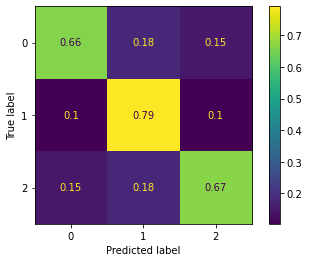

In [ ]:
print('accuracy_score:', accuracy_score(all_targets, all_predictions))
print(classification_report(all_targets, all_predictions, digits=4))
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

c = confusion_matrix(all_targets, all_predictions, normalize="true")
disp = ConfusionMatrixDisplay(c)
disp.plot()
plt.show()